In [37]:
# tai lieu tham khao
# 1. NCKH - K20
# 2. Fall Detection with Attention mechanisms
# 3. project1.pdf (bao cao kieu nhu pbl cua sinh vien truong UK)
# 4. https://phamdinhkhanh.github.io/2019/12/02/DeepLearningLayer.html
# 5. https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html
# 6. Data Science from Scratch - First Principles with Python (2015) (tks nkd)


In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, Flatten, Attention, Bidirectional, GlobalAvgPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.utils import resample

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
X = []
Y = []
no_of_timesteps = 20

In [3]:
def generate_sequences(dataset, no_of_timesteps, original_fps=30, target_fps=15):
    sequences = []
    skip_steps = original_fps // target_fps
    
    max_start_index = len(dataset) - skip_steps * no_of_timesteps
    
    for start in range(0, len(dataset)):
        sequence = []
        for i in range(no_of_timesteps):
            idx = start + skip_steps * i
            if idx >= len(dataset):
                break
            sequence.append(dataset[idx])
        if len(sequence) == no_of_timesteps:
            sequences.append(np.array(sequence))
    
    return sequences

In [4]:
extracted_features_path = 'extracted_features/may/2_1/'

In [5]:
fall_df = pd.read_csv(extracted_features_path + "train/FALL.csv")
not_fall_df = pd.read_csv(extracted_features_path + "train/NOT_FALL.csv")

grouped = fall_df.groupby('videoid') 

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    sequences = generate_sequences(dataset, no_of_timesteps)
    
    for sequence in sequences:
        X.append(sequence)
        Y.append(1) 

grouped = not_fall_df.groupby('videoid')

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    
    sequences = generate_sequences(dataset, no_of_timesteps)
    for sequence in sequences:
        X.append(sequence)
        Y.append(0) 

In [6]:
fall_df_test = pd.read_csv(extracted_features_path + "test2/FALL.csv")
not_fall_df_test = pd.read_csv(extracted_features_path + "test2/NOT_FALL.csv")

X_test = []
Y_test = []
Video_IDs_test = [] 

grouped = fall_df_test.groupby('videoid') 

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    #dataset = resample(dataset, replace=True, n_samples=dataset.shape[0]*4)
    sequences = generate_sequences(dataset, no_of_timesteps)
    
    for sequence in sequences:
        X_test.append(sequence)
        Y_test.append(1) 
        Video_IDs_test.append(video_id)
      
grouped = not_fall_df_test.groupby('videoid')

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    
    sequences = generate_sequences(dataset, no_of_timesteps)
    for sequence in sequences:
        X_test.append(sequence)
        Y_test.append(0) 
        Video_IDs_test.append(video_id)

In [7]:
fall_df_val = pd.read_csv(extracted_features_path + "val/FALL.csv")
not_fall_df_val = pd.read_csv(extracted_features_path + "val/NOT_FALL.csv")

X_val = []
Y_val = []

grouped = fall_df_val.groupby('videoid') 

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    sequences = generate_sequences(dataset, no_of_timesteps)
    
    for sequence in sequences:
        X_val.append(sequence)
        Y_val.append(1) 
      
grouped = not_fall_df_val.groupby('videoid')

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    
    sequences = generate_sequences(dataset, no_of_timesteps)
    for sequence in sequences:
        X_val.append(sequence)
        Y_val.append(0) 

In [8]:


X_train, Y_train = np.array(X), np.array(Y)
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_test, Y_test = np.array(X_test), np.array(Y_test)
#X_val = X_test
#Y_val = Y_test
#X_val = np.concatenate((X_val, X_test))
#Y_val = np.concatenate((Y_val, Y_test))

'''
X_full = np.concatenate((X_train, X_val, X_test))
Y_full = np.concatenate((Y_train, Y_val, Y_test))

print(X_full.shape)

X_train, X_val, Y_train, Y_val = train_test_split(X_full, Y_full, test_size=0.3, shuffle=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, shuffle=True)
'''
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(81445, 20, 132)
(8427, 20, 132)
(4599, 20, 132)


[51570 29875]
[6329 2098]
[3318 1281]


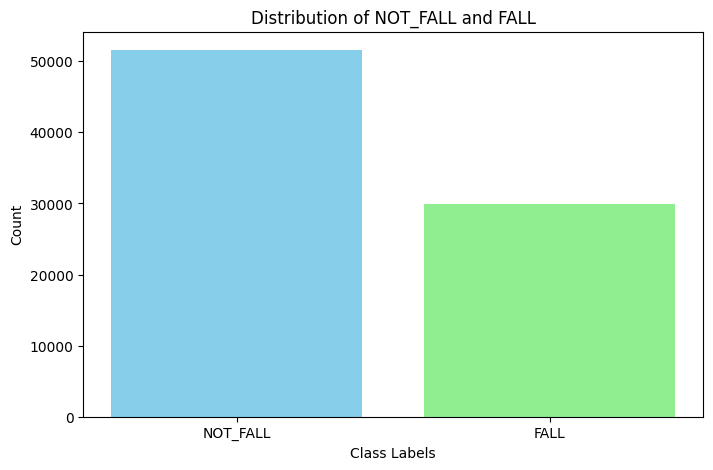

In [9]:
# Counting the occurrences of each value
values, counts = np.unique(Y_train, return_counts=True)
print(counts)

values_val, counts_val = np.unique(Y_val, return_counts=True)
print(counts_val)

values_test, counts_test = np.unique(Y_test, return_counts=True)
print(counts_test)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(values, counts, tick_label=['NOT_FALL', 'FALL'], color=['skyblue', 'lightgreen'])
plt.title('Distribution of NOT_FALL and FALL')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.show()

In [10]:
np.random.seed(16)
tf.random.set_seed(16)

model = Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SeqSelfAttention(units=128, attention_activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))) 
model.add(GlobalAvgPool1D())
model.add(Dense(64))
model.add(Dense(1, activation='sigmoid'))

epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000001), #0.000005
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            50432     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 seq_self_attention (SeqSelf  (None, 20, 64)           16641     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

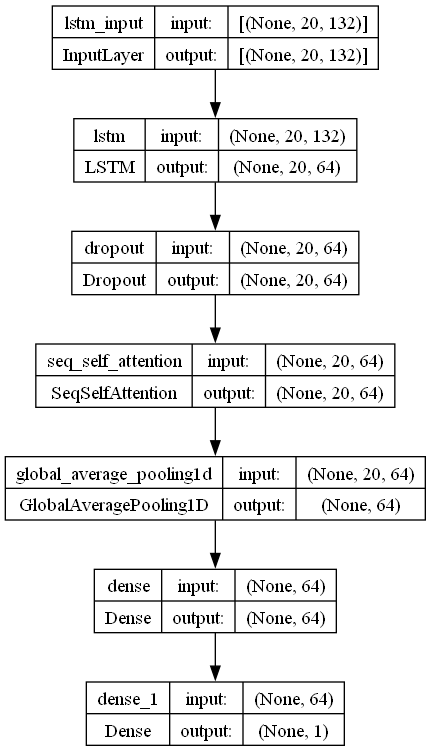

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
class EarlyStoppingAtMaxF1(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        val_precision = logs.get("val_precision")
        '''
        if val_precision == 1:
            self.model.stop_training = True
            return
        '''
        
        val_recall = logs.get("val_recall")
        current_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)
        
        #print(f" - val_f1: {current_f1:.4f}")

        if current_f1 > self.best:
            self.best = current_f1
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch for F1.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping with max val_f1 of {self.best:.4f}")   
             
t_callbacks = [
    #tf.keras.callbacks.LearningRateScheduler(lr_scheduler), 
    #keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
    EarlyStoppingAtMaxF1(patience = 15)
]

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    shuffle = True,
                    validation_data=(X_val, Y_val),
                    callbacks=t_callbacks
                   )

Epoch 1/25
2546/2546 [==============================] - 13s 5ms/step - loss: 0.6250 - accuracy: 0.6317 - precision: 0.1728 - recall: 0.0011 - val_loss: 0.5493 - val_accuracy: 0.7489 - val_precision: 0.2500 - val_recall: 0.0043
Epoch 2/25
2546/2546 [==============================] - 12s 5ms/step - loss: 0.5883 - accuracy: 0.6390 - precision: 0.5604 - recall: 0.0741 - val_loss: 0.5171 - val_accuracy: 0.7274 - val_precision: 0.3969 - val_recall: 0.1826
Epoch 3/25
2546/2546 [==============================] - 12s 5ms/step - loss: 0.5536 - accuracy: 0.6935 - precision: 0.6757 - recall: 0.3165 - val_loss: 0.4873 - val_accuracy: 0.7591 - val_precision: 0.5223 - val_recall: 0.3804
Epoch 4/25
2546/2546 [==============================] - 12s 5ms/step - loss: 0.5242 - accuracy: 0.7305 - precision: 0.6882 - recall: 0.4850 - val_loss: 0.4696 - val_accuracy: 0.7598 - val_precision: 0.5171 - val_recall: 0.5348
Epoch 5/25
2546/2546 [==============================] - 11s 5ms/step - loss: 0.5010 - accura

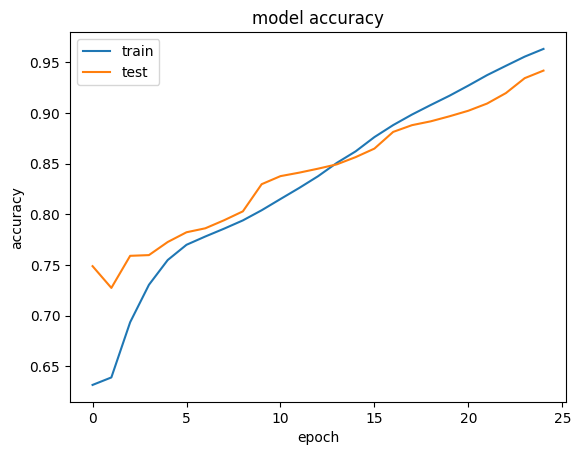

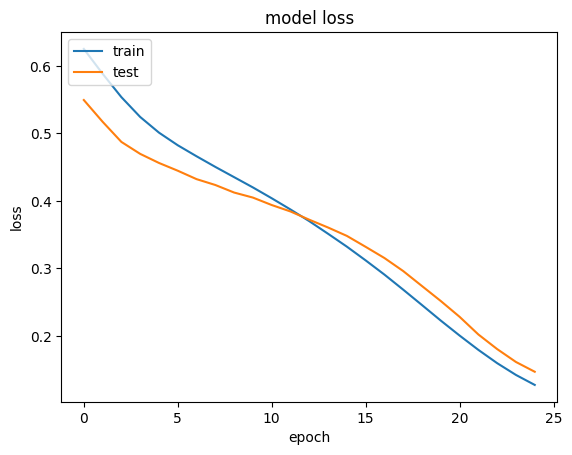

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


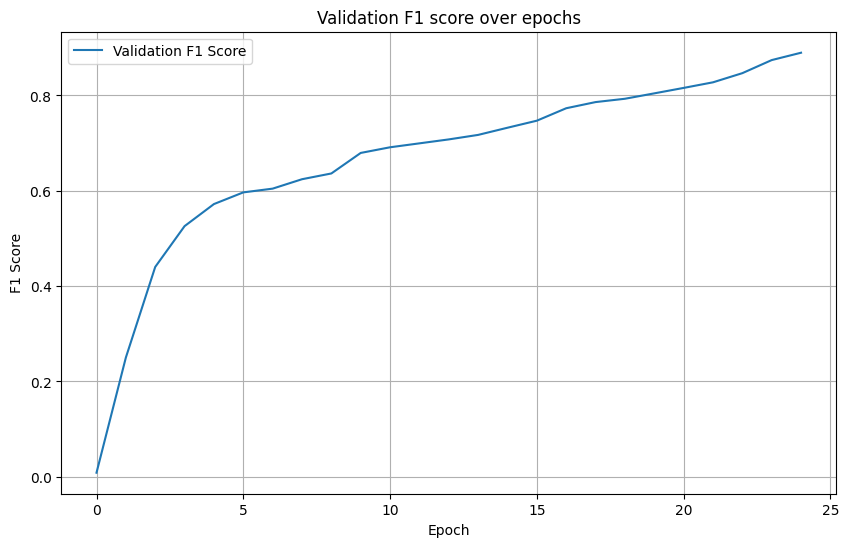

In [17]:
def calculate_f1_scores(precision, recall):
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_scores

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

val_f1_scores = calculate_f1_scores(np.array(val_precision), np.array(val_recall))


plt.figure(figsize=(10, 6))
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Validation F1 score over epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model_evaluation_history = model.evaluate(X_test, Y_test)

precision = model_evaluation_history[2] 
recall = model_evaluation_history[3] 
f1_score = 2 * (precision * recall) / (precision + recall)
print("f1_score =", f1_score)

144/144 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 0.9748 - precision: 0.9436 - recall: 0.9672
f1_score = 0.9552814149075012


In [19]:
y_scores = model.predict(X_test)

y_pred = (y_scores > 0.5).astype("int32")
y_pred = np.reshape(y_pred, -1)

y_true = Y_test

144/144 [==============================] - 0s 2ms/step


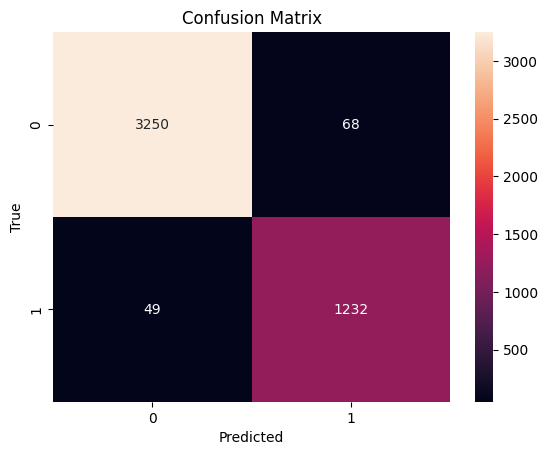

In [171]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [126]:
incorrect_indices = np.where(y_pred != y_true)[0]
incorrect_samples_dict = {}

for idx in incorrect_indices:
    incorrect_samples_dict[Video_IDs_test[idx]] = {
        "filename": Video_IDs_test[idx],
        "data":X_test[idx][0][0:2],
        "predicted": y_pred[idx],
        "actual": y_true[idx]
    }
incorrect_samples_info = list(incorrect_samples_dict.values())
incorrect_samples_info

[{'filename': 'test\\UR\\FALL\\fall-20-cam0-rgb.mp4_107',
  'data': array([0.64673364, 0.48459631]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'test\\UR\\FALL\\fall-20-cam0-rgb.mp4_flip_247',
  'data': array([0.35304251, 0.48646659]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'testclone2\\UR\\FALL\\fall-20-cam0-rgb.mp4_107',
  'data': array([0.64673364, 0.48459631]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'testclone2\\UR\\FALL\\fall-20-cam0-rgb.mp4_flip_247',
  'data': array([0.35304251, 0.48646659]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'testclone3\\UR\\FALL\\fall-20-cam0-rgb.mp4_107',
  'data': array([0.64673364, 0.48459631]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'testclone3\\UR\\FALL\\fall-20-cam0-rgb.mp4_flip_247',
  'data': array([0.35304251, 0.48646659]),
  'predicted': 0,
  'actual': 1},
 {'filename': 'testclone4\\UR\\FALL\\fall-20-cam0-rgb.mp4_107',
  'data': array([0.64673364, 0.48459631]),
  'predicted': 0,
  'actual': 1},
 {'filenam

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

filename = "model_may_scale_6_4_pi_highest"
with open(filename + '.tflite', 'wb') as f:
  f.write(tflite_model)

model.save(filename + ".h5")

INFO:tensorflow:Assets written to: C:\Users\caokh\AppData\Local\Temp\tmpcfj96ixs\assets


INFO:tensorflow:Assets written to: C:\Users\caokh\AppData\Local\Temp\tmpcfj96ixs\assets


In [12]:
model.load_weights("model_may_scale_6_4_pi_highest.h5")

In [54]:
extracted_features_path_pi_test = 'extracted_features/pi_test/'
fall_df_pi_test = pd.read_csv(extracted_features_path_pi_test + "FALL.csv")
not_fall_df_pi_test = pd.read_csv(extracted_features_path_pi_test + "NOT_FALL.csv")

X_pi_test = []
Y_pi_test = []
Video_IDs_pi_test = [] 
grouped = fall_df_pi_test.groupby('videoid') 

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    sequences = generate_sequences(dataset, no_of_timesteps)
    
    for sequence in sequences:
        X_pi_test.append(sequence)
        Y_pi_test.append(1) 
        Video_IDs_pi_test.append(video_id)
grouped = not_fall_df_pi_test.groupby('videoid')

for video_id, group in grouped:
    dataset = group.iloc[:, 2:].values 
    
    sequences = generate_sequences(dataset, no_of_timesteps)
    for sequence in sequences:
        X_pi_test.append(sequence)
        Y_pi_test.append(0) 
        Video_IDs_pi_test.append(video_id)

X_pi_test, Y_pi_test = np.array(X_pi_test), np.array(Y_pi_test)

In [55]:
model_test_history = model.evaluate(X_pi_test, Y_pi_test)

precision = model_test_history[2] 
recall = model_test_history[3] 
f1_score = 2 * (precision * recall) / (precision + recall)
print("f1_score =", f1_score)

333/333 [==============================] - 1s 3ms/step - loss: 0.4896 - accuracy: 0.8976 - precision: 0.9070 - recall: 0.8778
f1_score = 0.8921675610982129


Precision: 0.9070235459851077
Recall: 0.8782151208106002
F1 Score: 0.8923868923868924


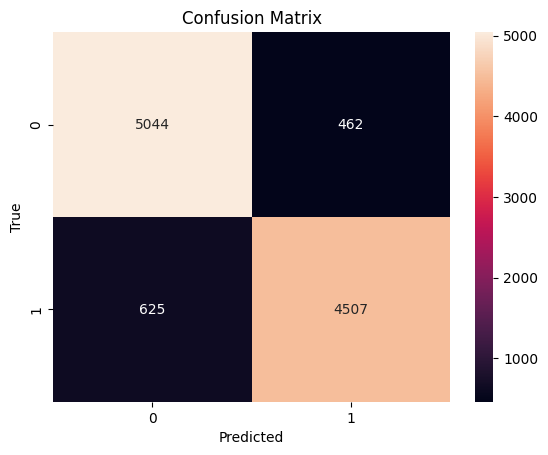

In [56]:
interpreter = tf.lite.Interpreter(model_path='model_may_scale_6_4_pi_highest.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

predictions = []
for i in range(len(X_pi_test)):
    input_data = np.array(X_pi_test[i], dtype=np.float32).reshape(input_shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

predictions = np.array(predictions).squeeze() 
true_labels = np.array(Y_pi_test).squeeze() 

predicted_labels = (predictions >= 0.5).astype(int)

TP = np.sum((predicted_labels == 1) & (true_labels == 1))
FP = np.sum((predicted_labels == 1) & (true_labels == 0))
FN = np.sum((predicted_labels == 0) & (true_labels == 1))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
incorrect_indices = np.where(predicted_labels != true_labels)[0]
incorrect_samples_dict = {}

for idx in incorrect_indices:
    incorrect_samples_dict[Video_IDs_pi_test[idx]] = {
        "filename": Video_IDs_pi_test[idx],
        "data":X_pi_test[idx][0][0:2],
        "predicted": predicted_labels[idx],
        "actual": true_labels[idx]
    }
incorrect_samples_info = list(incorrect_samples_dict.values())
len(incorrect_indices)

1503

In [53]:

from collections import defaultdict

incorrect_indices = np.where(predicted_labels != true_labels)[0]
incorrect_samples_dict = {}

# Create a dictionary to store the count of incorrect samples for each filename
filename_counts = defaultdict(int)

# Populate the incorrect_samples_dict and count occurrences
for idx in incorrect_indices:
    filename = Video_IDs_pi_test[idx]
    incorrect_samples_dict[filename] = {
        "filename": filename,
        #"data": X_pi_test[idx][0][0:2],
        "predicted": predicted_labels[idx],
        "actual": true_labels[idx]
    }
    filename_counts[filename] += 1

# Add the count to each dictionary entry in incorrect_samples_dict
for filename in incorrect_samples_dict:
    incorrect_samples_dict[filename]['count'] = filename_counts[filename]

# Update the incorrect_samples_info list
incorrect_samples_info = list(incorrect_samples_dict.values())

# Display the updated incorrect_samples_info
incorrect_samples_info


[{'filename': 'pi_test_set\\videos\\real11.mp4_flip_crop2_rotate-5_1587',
  'predicted': 0,
  'actual': 1,
  'count': 1},
 {'filename': 'pi_test_set\\videos\\real11.mp4_flip_crop4_1249',
  'predicted': 0,
  'actual': 1,
  'count': 1},
 {'filename': 'pi_test_set\\videos\\real11.mp4_flip_crop4_rotate-5_1635',
  'predicted': 0,
  'actual': 1,
  'count': 1},
 {'filename': 'pi_test_set\\videos\\real11.mp4_flip_crop6_1299',
  'predicted': 0,
  'actual': 1,
  'count': 1},
 {'filename': 'pi_test_set\\videos\\real11.mp4_flip_crop6_rotate-5_1683',
  'predicted': 0,
  'actual': 1,
  'count': 2},
 {'filename': 'pi_test_set\\videos\\real11.mp4_flip_rotate-5_1539',
  'predicted': 0,
  'actual': 1,
  'count': 1},
 {'filename': 'pi_test_set\\videos\\real12.mp4_36',
  'predicted': 0,
  'actual': 1,
  'count': 8},
 {'filename': 'pi_test_set\\videos\\real12.mp4_crop2_72',
  'predicted': 0,
  'actual': 1,
  'count': 7},
 {'filename': 'pi_test_set\\videos\\real12.mp4_crop2_rotate-5_439',
  'predicted': 0,
